# Calculating the mean-free path using conductance calculations

In order to generate the data that is used to fit, run the code in [generate-data.ipynb](generate-data.ipynb). Or download the data, see [README.md](README.md).

In [1]:
import numpy as np
import holoviews as hv
import pandas as pd
hv.notebook_extension()
%opts Scatter (color='b') 

pd.set_option('display.max_columns', None)

# Mean free path $g \sim N_{ch} / (1 + L / \lambda_{MFP})$

We fit:
$1/g \sim  (1/N_{ch} + L / (\lambda_{MFP}N_{ch}))$

In [2]:
np.__version__

'1.15.4'

/home/bomin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bomin/anaconda3/envs/python3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/bomin/anaconda3/envs/python3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/bomin/anaconda3/envs/python3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/bomin/anaconda3/envs/python3/lib/python3.6/_collections_abc.py:841: Matp

:DynamicMap   [L,mu]
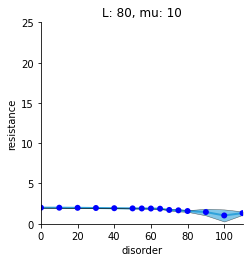

In [3]:
df = pd.read_hdf('data/mean_free_path.hdf')
gb = df.groupby(['disorder', 'L', 'mu', 'num_propagating'])['transmission']
conduction = gb.agg({'means' : np.mean, 'vars' : np.var}).reset_index()

d = {}
for key, gr in conduction.groupby(['L', 'mu']):
    d[key] = (hv.Curve((gr.disorder, gr.means), kdims=['disorder'], vdims=['resistance']) *
              hv.Spread((gr.disorder, gr.means, gr.vars)) *
              hv.Scatter((gr.disorder, gr.means)))[:, 0:25]
hv.util.Dynamic(hv.HoloMap(d, kdims=['L', 'mu']))

### Using a simple polyfit to find  $\lambda_{MFP}$

In [7]:
for (mu, disorder), gr in conduction.groupby(['mu', 'disorder']):
    modes = gr.num_propagating.values[0]
    fit = np.polyfit(gr.L, 1/gr.means, deg=1)
    mfp = 1 / (modes * fit[0])
#    print("mu: {} meV, disorder: {} meV, mfp: {:.0f} nm, num modes: {}".format(mu, disorder, mfp, modes))

### Using bootstrapping to find $\lambda_{MFP}$

In [8]:
from functools import partial
from scipy import optimize

def fit_bootstrap(p0, datax, datay, function, yerr_systematic=0.0):
    """From http://stackoverflow.com/a/21844726/3447047"""
    errfunc = lambda p, x, y: function(x, p) - y

    # Fit first time
    pfit, perr = optimize.leastsq(errfunc, p0, args=(datax, datay), full_output=0)


    # Get the stdev of the residuals
    residuals = errfunc(pfit, datax, datay)
    sigma_res = np.std(residuals)

    sigma_err_total = np.sqrt(sigma_res**2 + yerr_systematic**2)

    # 100 random data sets are generated and fitted
    ps = []
    for i in range(100):

        randomDelta = np.random.normal(0., sigma_err_total, len(datay))
        randomdataY = datay + randomDelta

        randomfit, randomcov = optimize.leastsq(
            errfunc, p0, args=(datax, randomdataY), full_output=0)

        ps.append(randomfit) 

    ps = np.array(ps)
    mean_pfit = np.mean(ps,0)

    # You can choose the confidence interval that you want for your
    # parameter estimates: 
    Nsigma = 2. # 1sigma gets approximately the same as methods above
                # 1sigma corresponds to 68.3% confidence interval
                # 2sigma corresponds to 95.44% confidence interval
    err_pfit = Nsigma * np.std(ps, 0) 

    pfit_bootstrap = mean_pfit
    perr_bootstrap = err_pfit
    return pfit_bootstrap, perr_bootstrap 

def inv_conductance(L, lambda_mfp, N_ch):
    return 1 / N_ch + L / (lambda_mfp * N_ch)

for (mu, disorder), gr in conduction.groupby(['mu', 'disorder']):
    modes = gr.num_propagating.values[0]
    ff = partial(inv_conductance, N_ch=modes)
    xdata = gr.L
    ydata = 1 / gr.means
    pstart = 1000
    pfit, perr = fit_bootstrap(pstart, xdata, ydata, ff)
    print("mu: {} meV, disorder: {} meV, mfp: {:.0f} nm ± {:.0f}".format(mu, disorder, pfit[0], perr[0]))

mu: 10 meV, disorder: 0 meV, mfp: 937220507561 nm ± 697845910647
mu: 10 meV, disorder: 10 meV, mfp: 47102 nm ± 1323
mu: 10 meV, disorder: 20 meV, mfp: 13556 nm ± 468
mu: 10 meV, disorder: 30 meV, mfp: 4579 nm ± 168
mu: 10 meV, disorder: 40 meV, mfp: 2874 nm ± 185
mu: 10 meV, disorder: 50 meV, mfp: 1164 nm ± 55
mu: 10 meV, disorder: 55 meV, mfp: 778 nm ± 76
mu: 10 meV, disorder: 60 meV, mfp: 586 nm ± 49
mu: 10 meV, disorder: 65 meV, mfp: 177 nm ± 20
mu: 10 meV, disorder: 70 meV, mfp: 19 nm ± 4
mu: 10 meV, disorder: 75 meV, mfp: 24 nm ± 7
mu: 10 meV, disorder: 80 meV, mfp: 27 nm ± 9
mu: 10 meV, disorder: 90 meV, mfp: 703823 nm ± 14005040
mu: 10 meV, disorder: 100 meV, mfp: 5 nm ± 2
mu: 10 meV, disorder: 110 meV, mfp: 60 nm ± 14
mu: 11 meV, disorder: 0 meV, mfp: 950628952636 nm ± 777350362644
mu: 11 meV, disorder: 10 meV, mfp: 46002 nm ± 2817
mu: 11 meV, disorder: 20 meV, mfp: 11200 nm ± 404
mu: 11 meV, disorder: 30 meV, mfp: 4256 nm ± 249
mu: 11 meV, disorder: 40 meV, mfp: 2270 nm ± 97
m

mu: 21 meV, disorder: 30 meV, mfp: 4125 nm ± 69
mu: 21 meV, disorder: 40 meV, mfp: 2438 nm ± 49
mu: 21 meV, disorder: 50 meV, mfp: 862 nm ± 27
mu: 21 meV, disorder: 55 meV, mfp: 614 nm ± 33
mu: 21 meV, disorder: 60 meV, mfp: 529 nm ± 26
mu: 21 meV, disorder: 65 meV, mfp: 303 nm ± 18
mu: 21 meV, disorder: 70 meV, mfp: 232 nm ± 17
mu: 21 meV, disorder: 75 meV, mfp: 218 nm ± 18
mu: 21 meV, disorder: 80 meV, mfp: 175 nm ± 19
mu: 21 meV, disorder: 90 meV, mfp: 109 nm ± 15
mu: 21 meV, disorder: 100 meV, mfp: 119 nm ± 9
mu: 21 meV, disorder: 110 meV, mfp: 83 nm ± 14
mu: 22 meV, disorder: 0 meV, mfp: 1185982189427 nm ± 980296285563
mu: 22 meV, disorder: 10 meV, mfp: 49174 nm ± 1678
mu: 22 meV, disorder: 20 meV, mfp: 11696 nm ± 202
mu: 22 meV, disorder: 30 meV, mfp: 1955 nm ± 64
mu: 22 meV, disorder: 40 meV, mfp: 1100 nm ± 31
mu: 22 meV, disorder: 50 meV, mfp: 760 nm ± 21
mu: 22 meV, disorder: 55 meV, mfp: 458 nm ± 26
mu: 22 meV, disorder: 60 meV, mfp: 343 nm ± 19
mu: 22 meV, disorder: 65 meV, 